In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model


import pandas as pd
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
from google.colab import drive 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
!unzip /content/drive/MyDrive/kaggle_Computer_Vision/state-farm-distracted-driver-detection.zip -d /content/kaggle_Computer_Vision

In [3]:
df = pd.read_csv('/content/kaggle_Computer_Vision/driver_imgs_list.csv')

df.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

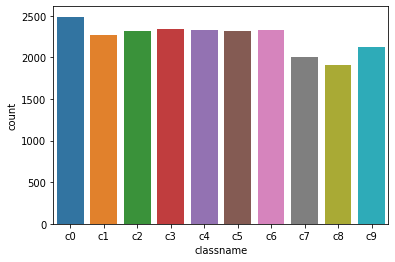

In [4]:
sns.countplot(data = df, x='classname')

In [5]:
class_dict = {0 : "safe driving",
              1 : "texting - right",
              2 : "talking on the phone - right",
              3 : "texting - left",
              4 : "talking on the phone - left",
              5 : "operating the radio",
              6 : "drinking",
              7 : "reaching behind",
              8 : "hair and makeup",
              9 : "talking to passenger"}


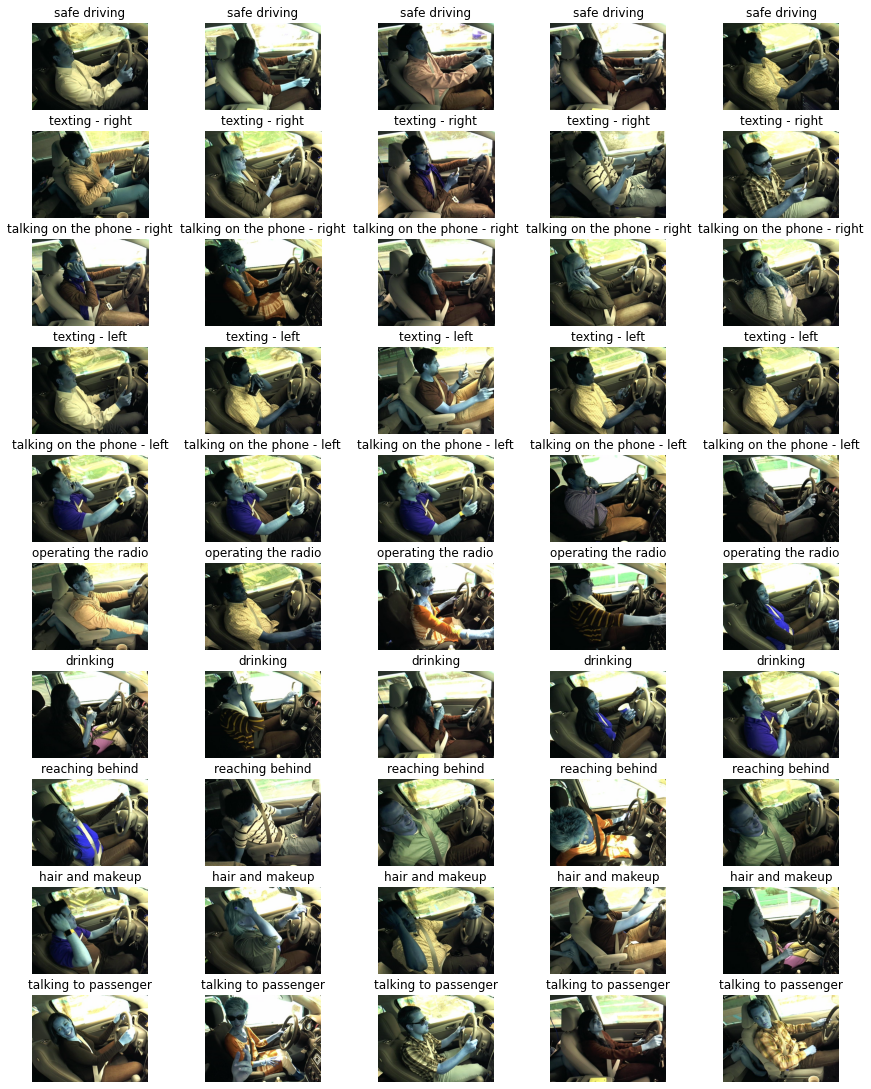

In [6]:
n = 5
m = len(class_dict)
train_path = '/content/kaggle_Computer_Vision/imgs/train/' 
test_path = '/content/kaggle_Computer_Vision/imgs/' 

fig, ax = plt.subplots(nrows = m, ncols = n, figsize=(12, 15))
plt.tight_layout(pad=0.0)

for i in range(m):
  train_image_dir = os.path.join(train_path, 'c'+str(i))
  image_names = os.listdir(train_image_dir)
  
  for j in range(n):

    img = cv.imread(train_image_dir+'/' + image_names[j])

    ax[i,j].imshow(img)
    ax[i,j].axis('off')
    ax[i,j].set_title(class_dict[i])


In [140]:
batch_size = 500
validation_split = 0.2
seed = 1234
h = 64
w = 64
c = 3

In [141]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split = validation_split)
test_datagen = ImageDataGenerator(rescale=1./255)

In [142]:
train_data = train_datagen.flow_from_directory(train_path, target_size= (h,w), batch_size=batch_size, subset='training', seed=seed)



Found 17943 images belonging to 10 classes.


In [143]:

valid_data = train_datagen.flow_from_directory(train_path, target_size= (h,w), batch_size=batch_size, subset='validation', shuffle = False, seed=seed)

Found 4481 images belonging to 10 classes.


In [145]:
test_data = test_datagen.flow_from_directory(test_path, target_size= (h,w), batch_size=batch_size, classes = ['test'], seed=seed)

Found 79726 images belonging to 1 classes.


In [146]:
#Model CNN

model_name = 'CNN_model_CV.h5'
checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model = models.Sequential()
model.add(layers.Conv2D(256, (3, 3), strides=1,padding='Same', activation='relu', input_shape=(h,w,c), data_format = 'channels_last'))
model.add(layers.MaxPooling2D((2, 2)))




model.add(layers.Flatten())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(256, activation='relu'))




model.add(layers.Dense(len(class_dict), activation = 'softmax'))

model.compile(loss= 'categorical_crossentropy', optimizer= Adam(learning_rate=0.0001),metrics=['accuracy', tf.keras.metrics.AUC()])

In [147]:
n_epochs = 25

In [ ]:
history = model.fit(train_data,  epochs = n_epochs, validation_data = valid_data,  callbacks=[checkpoint], verbose = 1)

Epoch 1/25
36/36 [==============================] - ETA: 0s - loss: 1.9759 - accuracy: 0.3885 - auc_11: 0.7723
Epoch 1: val_accuracy improved from -inf to 0.57933, saving model to CNN_model_CV.h5
36/36 [==============================] - 239s 6s/step - loss: 1.9759 - accuracy: 0.3885 - auc_11: 0.7723 - val_loss: 1.5053 - val_accuracy: 0.5793 - val_auc_11: 0.9204
Epoch 2/25
36/36 [==============================] - ETA: 0s - loss: 1.1148 - accuracy: 0.7728 - auc_11: 0.9652
Epoch 2: val_accuracy improved from 0.57933 to 0.80986, saving model to CNN_model_CV.h5
36/36 [==============================] - 225s 6s/step - loss: 1.1148 - accuracy: 0.7728 - auc_11: 0.9652 - val_loss: 0.8430 - val_accuracy: 0.8099 - val_auc_11: 0.9776
Epoch 3/25
36/36 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.8805 - auc_11: 0.9882
Epoch 3: val_accuracy improved from 0.80986 to 0.91520, saving model to CNN_model_CV.h5
36/36 [==============================] - 228s 6s/step - loss: 0.6513 -

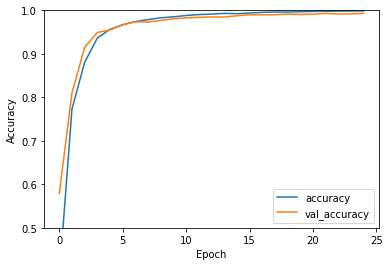

In [149]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

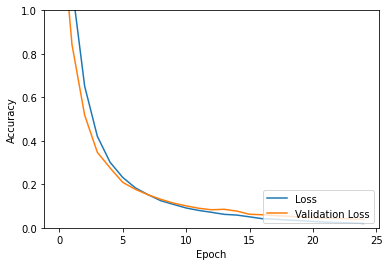

In [150]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

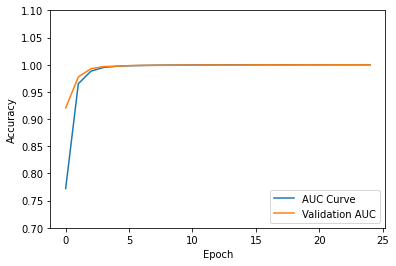

In [153]:
plt.plot(history.history['auc_11'], label='AUC Curve')
plt.plot(history.history['val_auc_11'], label = 'Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1.1])
plt.legend(loc='lower right')

In [154]:
model_saved = load_model('./CNN_model_CV.h5')

In [155]:
loss, accuracy, auc = model_saved.evaluate(valid_data)
print('The prediction accuracy is: ', accuracy)

9/9 [==============================] - 20s 2s/step - loss: 0.0447 - accuracy: 0.9931 - auc_11: 0.9998
The prediction accuracy is:  0.9930819272994995


In [156]:
#valid_data.reset()
y_pred_val = model_saved.predict(valid_data, verbose=1)

y_pred_val = np.argmax(y_pred_val, axis=1)

y_test_val = valid_data.labels



9/9 [==============================] - 20s 2s/step


Accuracy Score is : 99.31%
 
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       497
           1       1.00      1.00      1.00       453
           2       0.99      0.99      0.99       463
           3       1.00      0.99      1.00       469
           4       0.99      0.99      0.99       465
           5       1.00      0.99      0.99       462
           6       0.99      1.00      0.99       465
           7       0.99      0.99      0.99       400
           8       0.99      0.98      0.99       382
           9       0.99      1.00      0.99       425

    accuracy                           0.99      4481
   macro avg       0.99      0.99      0.99      4481
weighted avg       0.99      0.99      0.99      4481

 


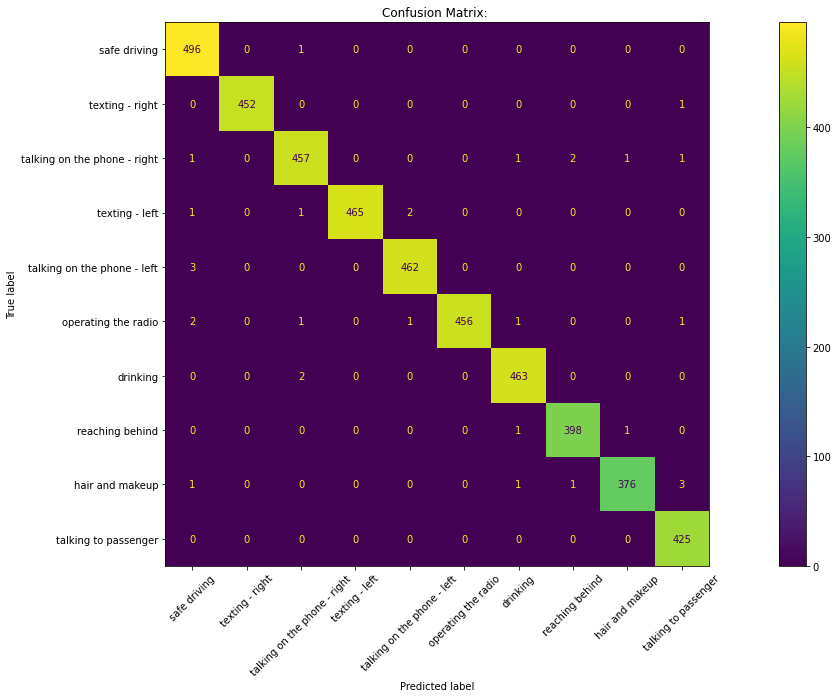

In [165]:

accuracy = accuracy_score(y_test_val, y_pred_val) 
print("Accuracy Score is : " + "{:.2%}".format(accuracy))
print(' ')
cm = confusion_matrix(y_test_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['safe driving','texting - right', "talking on the phone - right", "texting - left", "talking on the phone - left",
                                                                    "operating the radio", "drinking", "reaching behind", "hair and makeup", "talking to passenger"])
fig, ax = plt.subplots(figsize=(25,10))    
disp.plot(ax=ax, xticks_rotation = 45)
plt.title('Confusion Matrix: ')

print("Classification Report:")
print(classification_report(y_test_val, y_pred_val,  zero_division=1))
print(" ")
plt.show()

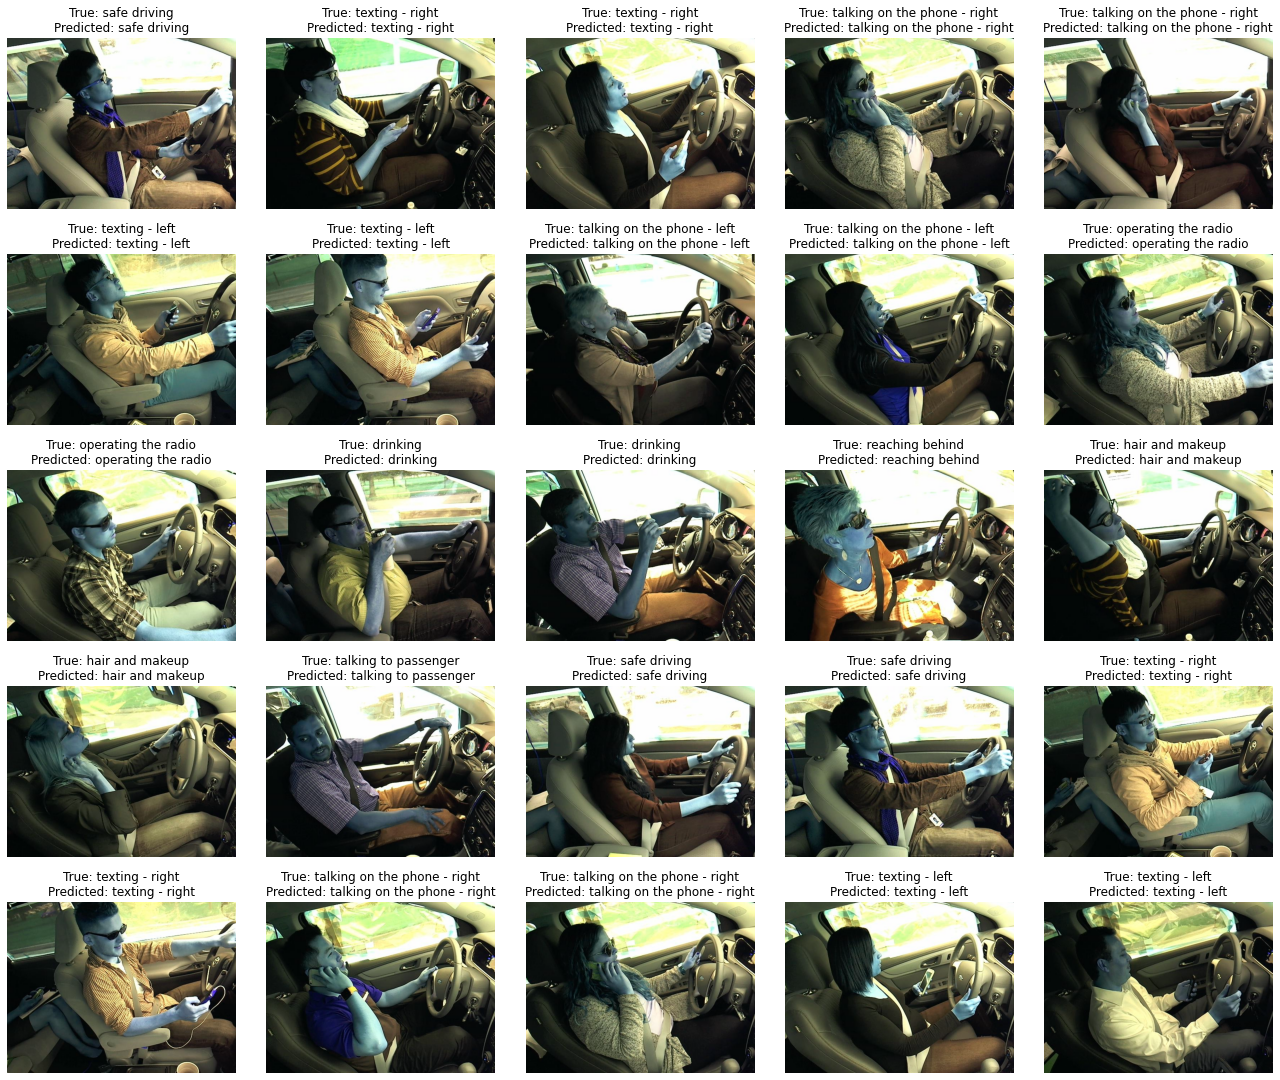

In [197]:
n = 5
m = 5


fig, ax = plt.subplots(nrows = m, ncols = n, figsize=(18, 15))
plt.tight_layout(pad=0.0)
r = 0
for i in range(m):
  for j in range(n):
  
    r = r + 250
 
    if r > len(valid_data.filenames):
      r = len(valid_data)

    t = y_test_val[r]
  
    p_name = valid_data.filenames[r]
    d = p_name[0:2]
    f = p_name[3:]

    train_image_dir = os.path.join(train_path, d)
  


    img = cv.imread(train_image_dir+'/' + f)

    ax[i,j].imshow(img)
    ax[i,j].axis('off')
    ax[i,j].set_title('True: ' + class_dict[t] + '\n' + 'Predicted: '+ class_dict[y_pred_val[r]])
 

In [166]:
#Predictions on test data

y_pred_test = model_saved.predict(test_data, verbose=1)

y_pred_test = np.argmax(y_pred_test, axis=1)

y_test_test = test_data.labels


160/160 [==============================] - 446s 3s/step
